# QEP Regression with Uncertain Inputs

## Introduction

In this notebook, we're going to demonstrate one way of dealing with uncertainty in our training data. Let's say that we're collecting training data that models the following function.

$$
\begin{align}
y &= \sin(2\pi x) + \epsilon \\
  \epsilon &\sim \mathcal{Q}(0, 0.2) 
\end{align}
$$

However, now assume that we're a bit uncertain about our features. In particular, we're going to assume that every `x_i` value is not a point but a distribution instead. E.g.

$$ x_i \sim \mathcal{Q}(\mu_i, \sigma_i). $$

### Using a distributional kernel to deal with uncertain inputs

Rather than using a variational method (see the QEP Regression with Uncertian Inputs tutorial in the variational examples), if we explicitly know the type of uncertainty in our inputs we can pass that into our kernel.

More specifically, assuming Gaussian inputs, we will compute the symmetrized KL divergence between the Q-exponential inputs.



In [1]:
import math
import torch
import tqdm
import qpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Training data is 100 points in [0,1] inclusive regularly spaced
train_x_mean = torch.linspace(0, 1, 20)
# We'll assume the variance shrinks the closer we get to 1
train_x_stdv = torch.linspace(0.03, 0.01, 20)

# True function is sin(2*pi*x) with Gaussian noise
train_y = torch.sin(train_x_mean * (2 * math.pi)) + torch.randn(train_x_mean.size()) * 0.2

To effectively pass in the training distributional data, we will need to stack the mean and log variances.

In [3]:
train_x_distributional = torch.stack((train_x_mean, (train_x_stdv**2).log()), dim=1)

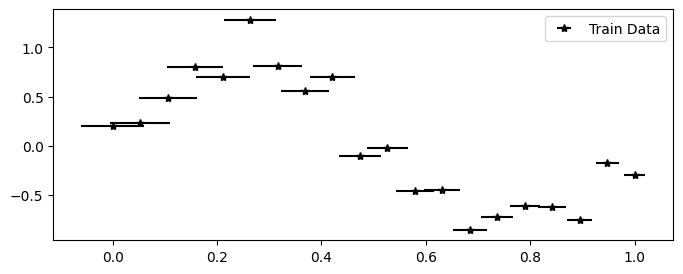

In [4]:
f, ax = plt.subplots(1, 1, figsize=(8, 3))
ax.errorbar(train_x_mean, train_y, xerr=(train_x_stdv * 2), fmt="k*", label="Train Data")
ax.legend()

We train the hyperparameters of the resulting distributional GP via type-II gradient descent, as is standard in many settings. We could also do fully Bayesian inference.

In [5]:
from qpytorch.models import ExactQEP
from qpytorch.kernels import QExponentialSymmetrizedKLKernel, ScaleKernel
from qpytorch.means import ConstantMean
POWER =1.0

class ExactQEPModel(ExactQEP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactQEPModel, self).__init__(train_x, train_y, likelihood)
        self.power = torch.tensor(POWER)
        self.mean_module = ConstantMean()
        self.covar_module = ScaleKernel(QExponentialSymmetrizedKLKernel())
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return qpytorch.distributions.MultivariateQExponential(mean_x, covar_x, power=self.power)

# initialize likelihood and model
likelihood = qpytorch.likelihoods.QExponentialLikelihood(power=torch.tensor(POWER))
model = ExactQEPModel(train_x_distributional, train_y, likelihood)

In [6]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 500


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.25)  # Includes QExponentialLikelihood parameters

# "Loss" for QEPs - the marginal log likelihood
mll = qpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x_distributional)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/500 - Loss: 1.597   lengthscale: 0.693   noise: 0.693
Iter 2/500 - Loss: 1.589   lengthscale: 0.826   noise: 0.576
Iter 3/500 - Loss: 1.508   lengthscale: 0.973   noise: 0.474
Iter 4/500 - Loss: 1.459   lengthscale: 1.133   noise: 0.387
Iter 5/500 - Loss: 1.418   lengthscale: 1.302   noise: 0.313
Iter 6/500 - Loss: 1.357   lengthscale: 1.483   noise: 0.251
Iter 7/500 - Loss: 1.290   lengthscale: 1.678   noise: 0.200
Iter 8/500 - Loss: 1.232   lengthscale: 1.884   noise: 0.158
Iter 9/500 - Loss: 1.181   lengthscale: 2.102   noise: 0.125
Iter 10/500 - Loss: 1.127   lengthscale: 2.327   noise: 0.098
Iter 11/500 - Loss: 1.066   lengthscale: 2.561   noise: 0.077
Iter 12/500 - Loss: 1.006   lengthscale: 2.800   noise: 0.060
Iter 13/500 - Loss: 0.952   lengthscale: 3.045   noise: 0.046
Iter 14/500 - Loss: 0.904   lengthscale: 3.294   noise: 0.036
Iter 15/500 - Loss: 0.857   lengthscale: 3.546   noise: 0.028
Iter 16/500 - Loss: 0.807   lengthscale: 3.801   noise: 0.021
Iter 17/500 - Los

Now, we test predictions. For simplicity, we will assume a fixed variance of $0.01.$

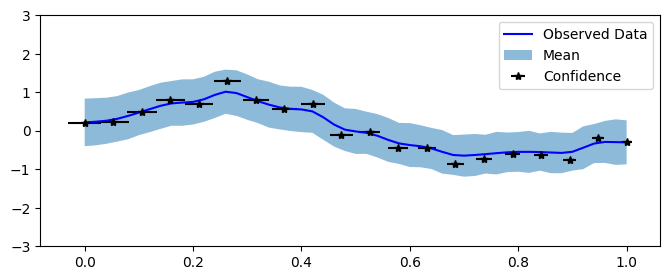

In [7]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), qpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    test_x_distributional = torch.stack((test_x, (1e-3 * torch.ones_like(test_x)).log()), dim=1)
    observed_pred = likelihood(model(test_x_distributional))

with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(8, 3))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region(rescale=True)
    # Plot training data as black stars
    ax.errorbar(train_x_mean.numpy(), train_y.numpy(), xerr=train_x_stdv, fmt='k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

As a final note, we've made it very easy to extend the distributional kernel class by exposing a generic `DistributionalInputKernel` class that takes as input any distance function over probability distributions.